# Importing the libaries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report  # Import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Loading the dataset and tokenization

In [2]:
# Load the dataset
df = pd.read_csv('final.csv')
text_column = 'tweet'  # Adjust if the column name is different

# Ensure all entries in the text column are strings
df[text_column] = df[text_column].astype(str).fillna('')

# Filter the dataset to include only hate speech (0), offensive language (1), and non-hate speech (2)
df = df[df['class'].isin([0, 1, 2])]

# Encode the labels (0 and 1 for hate speech, 2 for non-hate speech)
label_mapping = {0: 0, 1: 0, 2: 1}
df['label'] = df['class'].map(label_mapping)

# Split the data
X = df[text_column].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all training and test data are strings
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)  # Adjust num_words as needed
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_length = 100  # Adjust max_length as needed
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

print("Shape of training data:", X_train_pad.shape)
print("Shape of test data:", X_test_pad.shape)

Shape of training data: (19826, 100)
Shape of test data: (4957, 100)


# Model Definitions

In [3]:

# Define LSTM model with Dropout and different activation functions
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
    model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid'))  # Using tanh for LSTM cell and sigmoid for recurrent step
    model.add(Dropout(0.5))  # Adding dropout to prevent overfitting
    model.add(Dense(2, activation='softmax'))  # Using softmax for binary classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Adam optimizer
    return model

# Define Bidirectional LSTM model
def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
    model.add(Bidirectional(LSTM(128, activation='tanh', recurrent_activation='sigmoid')))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Training and Evaluation

In [4]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping], verbose=2)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Hate Speech', 'Non-Hate Speech'])
    return accuracy, report, history

# Create models
lstm_model = create_lstm_model()
bidirectional_lstm_model = create_bidirectional_lstm_model()
cnn_model = create_cnn_model()

# Train and evaluate models
accuracy_scores = {}
reports = {}
histories = {}

accuracy_scores['LSTM'], reports['LSTM'], histories['LSTM'] = train_and_evaluate_model(lstm_model, X_train_pad, y_train, X_test_pad, y_test)
accuracy_scores['Bidirectional LSTM'], reports['Bidirectional LSTM'], histories['Bidirectional LSTM'] = train_and_evaluate_model(bidirectional_lstm_model, X_train_pad, y_train, X_test_pad, y_test)
accuracy_scores['CNN'], reports['CNN'], histories['CNN'] = train_and_evaluate_model(cnn_model, X_train_pad, y_train, X_test_pad, y_test)

print("Accuracy Scores:", accuracy_scores)

# Print classification reports
for model_name, report in reports.items():
    print(f"Classification Report for {model_name}:\n{report}\n")


C:\Users\chish\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
496/496 - 56s - 112ms/step - accuracy: 0.9110 - loss: 0.2082 - val_accuracy: 0.9551 - val_loss: 0.1171
Epoch 2/20
496/496 - 51s - 103ms/step - accuracy: 0.9689 - loss: 0.0855 - val_accuracy: 0.9478 - val_loss: 0.1298
Epoch 3/20
496/496 - 50s - 101ms/step - accuracy: 0.9834 - loss: 0.0513 - val_accuracy: 0.9433 - val_loss: 0.1537
Epoch 4/20
496/496 - 57s - 114ms/step - accuracy: 0.9893 - loss: 0.0333 - val_accuracy: 0.9418 - val_loss: 0.2008
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
Epoch 1/20
496/496 - 71s - 144ms/step - accuracy: 0.9194 - loss: 0.1921 - val_accuracy: 0.9526 - val_loss: 0.1228
Epoch 2/20
496/496 - 60s - 121ms/step - accuracy: 0.9691 - loss: 0.0858 - val_accuracy: 0.9465 - val_loss: 0.1321
Epoch 3/20
496/496 - 65s - 131ms/step - accuracy: 0.9843 - loss: 0.0485 - val_accuracy: 0.9405 - val_loss: 0.2005
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
Epoch 1/20
496/496 - 18s - 36ms/step - accuracy: 0.9211 - loss: 0.1869 - val_accuracy: 0.9534 - val_loss: 0.1188
Epoch

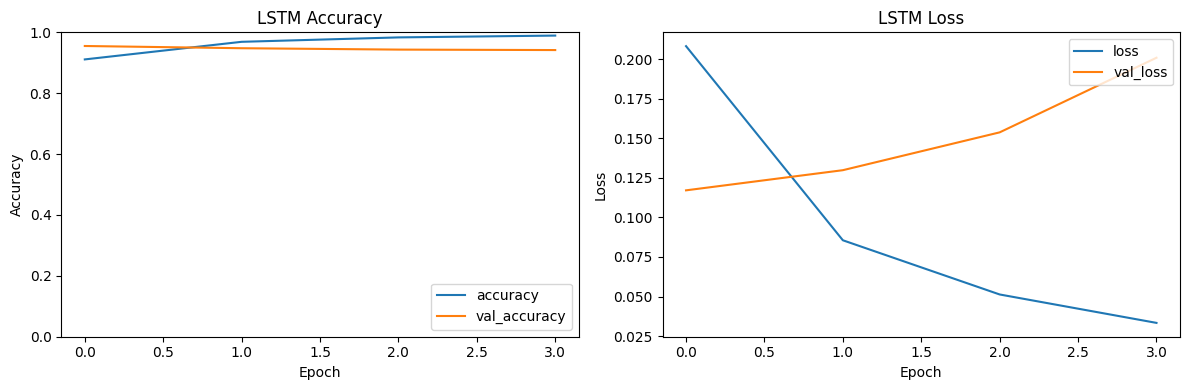

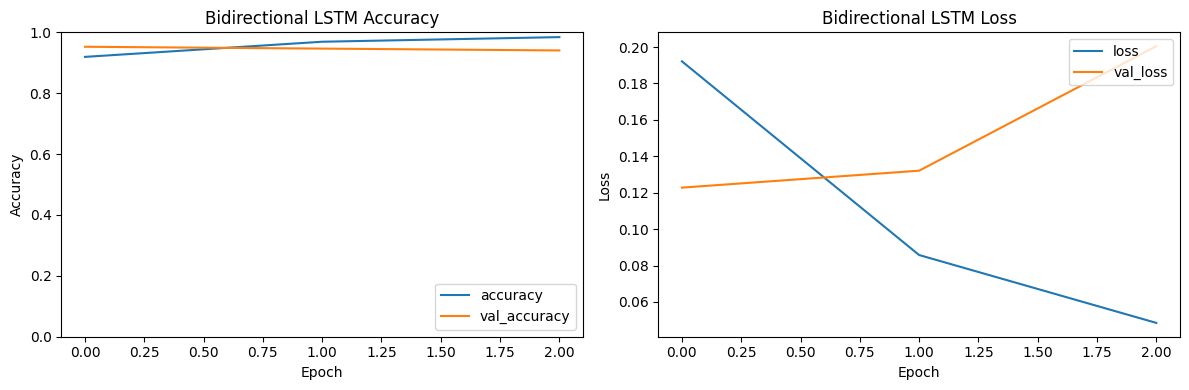

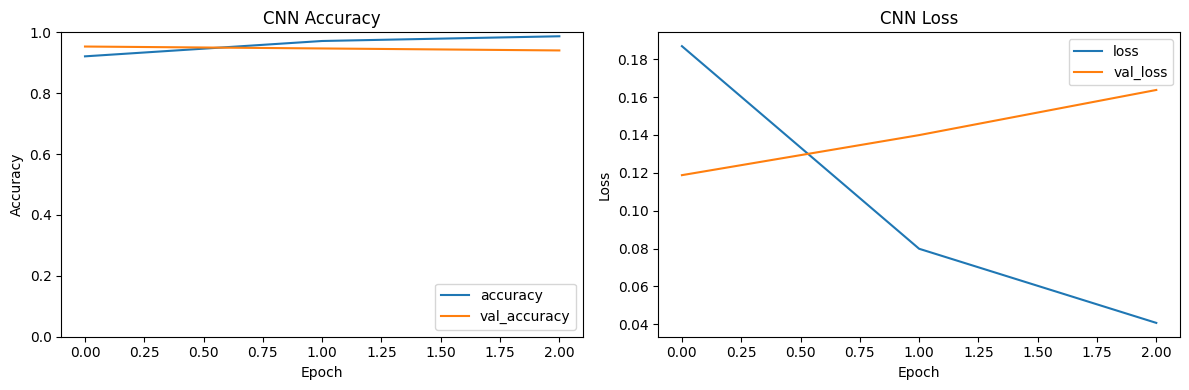

In [5]:
# Plotting training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} Loss')
    
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

# Plot history for each model
for model_name, history in histories.items():
    plot_history(history, model_name)

# Saving the Best Model

In [6]:
# Determine the best model
best_model_name = max(accuracy_scores, key=accuracy_scores.get)
best_model = None

if best_model_name == 'LSTM':
    best_model = lstm_model
elif best_model_name == 'Bidirectional LSTM':
    best_model = bidirectional_lstm_model
elif best_model_name == 'CNN':
    best_model = cnn_model

# Save the best model
best_model.save('best_deep_learning_model.h5')
print(f'The best model is {best_model_name} and it has been saved as best_deep_learning_model.h5')

# Load the best model
best_model = load_model('best_deep_learning_model.h5')

The best model is CNN and it has been saved as best_deep_learning_model.h5


#  Making Predictions

In [7]:
# Load the final dataset
final_df = pd.read_csv('labeled_data.csv')
final_df[text_column] = final_df[text_column].astype(str).fillna('')

# Filter the final dataset to include only hate speech (0), offensive language (1), and non-hate speech (2)
final_df = final_df[final_df['class'].isin([0, 1, 2])]

# Tokenize and pad the new data
X_new = final_df[text_column]
X_new_seq = tokenizer.texts_to_sequences(X_new)
X_new_pad = pad_sequences(X_new_seq, maxlen=max_length)

# Predict using the best model
new_predictions = best_model.predict(X_new_pad)
new_predictions_labels = np.argmax(new_predictions, axis=1)

# Map predictions to labels
new_predictions_labels = LabelEncoder().fit_transform(new_predictions_labels)

# Add predictions to the dataframe
final_df['predictions'] = new_predictions_labels

# Save the predictions to a CSV file
final_df.to_csv('final_with_deep_learning_predictions.csv', index=False)

# Print the predictions
print(final_df[['tweet', 'predictions']])

775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
                                                   tweet  predictions
0      !!! RT @mayasolovely: As a woman you shouldn't...            1
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...            0
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...            0
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...            0
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...            0
...                                                  ...          ...
24778  you's a muthaf***in lie &#8220;@LifeAsKing: @2...            0
24779  you've gone and broke the wrong heart baby, an...            1
24780  young buck wanna eat!!.. dat nigguh like I ain...            0
24781              youu got wild bitches tellin you lies            0
24782  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...            1

[24783 rows x 2 columns]
